In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
papers = pd.read_csv("covid19_papers_compiled.csv")

In [11]:
#load in authors and citations as list
with open("covid_authors_list.txt", "rb") as fp:
    b = pickle.load(fp)
papers['Authors'] = b
with open("covid_citations_list.txt", "rb") as fp:
    b = pickle.load(fp)
papers['Citations'] = b

In [22]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import scispacy
import spacy
import en_core_sci_md

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sb
import matplotlib.pyplot as plt

### Parse texts using spacy module

In [23]:
nlp = en_core_sci_md.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2000000

#define tokenizer
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not 
            (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 
    'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True


In [32]:
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, max_features=800000)
data_vectorized = vectorizer.fit_transform(tqdm(all_texts))

joblib.dump(vectorizer, 'vectorizer.csv')
joblib.dump(data_vectorized, 'data_vectorized.csv')

['Defaults',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_docs_and_golds',
 '_meta',
 '_multiprocessing_pipe',
 '_optimizer',
 '_path',
 'add_pipe',
 'begin_training',
 'create_pipe',
 'disable_pipes',
 'entity',
 'evaluate',
 'factories',
 'from_bytes',
 'from_disk',
 'get_pipe',
 'has_pipe',
 'lang',
 'linker',
 'make_doc',
 'matcher',
 'max_length',
 'meta',
 'parser',
 'path',
 'pipe',
 'pipe_factories',
 'pipe_labels',
 'pipe_names',
 'pipeline',
 'preprocess_gold',
 'rehearse',
 'remove_pipe',
 'rename_pipe',
 'replace_pipe',
 'resume_training',
 'tagger',
 'tensorizer',
 'to_bytes',
 'to_disk',
 'tokenizer',
 'update',
 'use_params',
 'v

In [34]:
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, max_features=800000)
data_vectorized = vectorizer.fit_transform(tqdm(papers['Text']))

joblib.dump(vectorizer, 'vectorizer.csv')
joblib.dump(data_vectorized, 'data_vectorized.csv')

100%|██████████| 29315/29315 [09:38<00:00, 50.72it/s] 


['data_vectorized.csv']

In [36]:
data_vectorized.shape,type(data_vectorized)

((29315, 800000), scipy.sparse.csr.csr_matrix)

What are the most frequently used words?

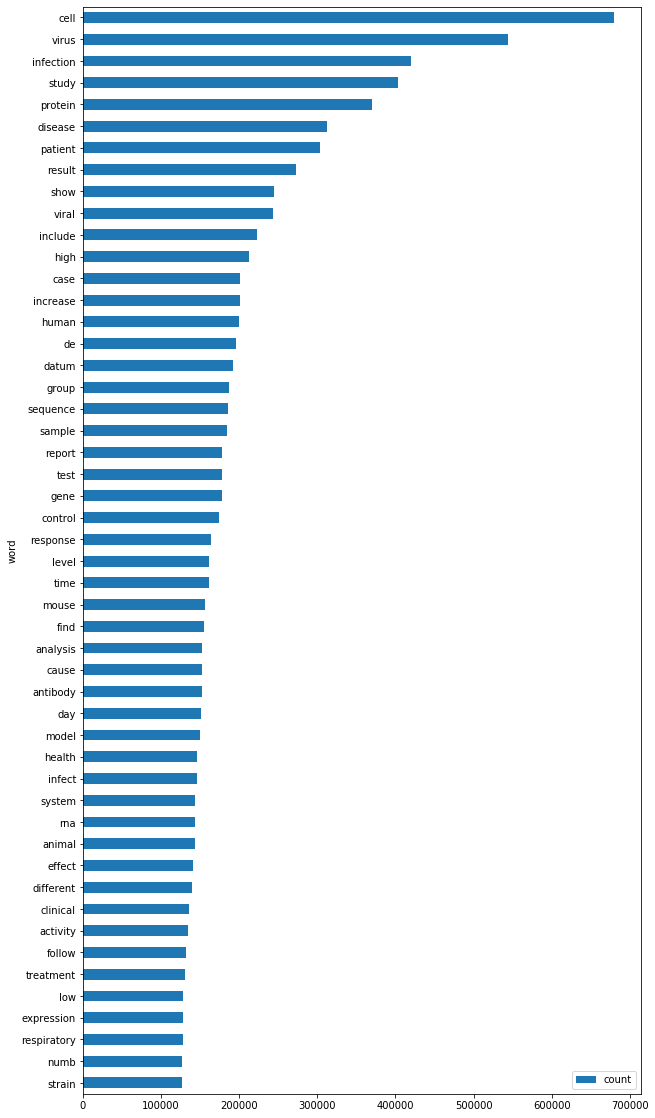

In [43]:
# most frequent words
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 
                           'count': np.asarray(data_vectorized.sum(axis=0))[0]})

word_count.sort_values('count', 
                       ascending=False).set_index('word')[:50].sort_values('count', 
                                                                           ascending=True).plot(kind='barh',figsize=(10,20))




### Notes on the Dirichlet Distribution

Mulitvariate version of the beta distribution.

The beta distibution is use to draw a conjugate prior from two paramters $\alpha$ and $\beta$. The probablilty of drawing $x$ conditioned on $\alpha$ and $\beta$ is:

$
\begin{align}
f(x; \alpha, \beta) = constant \cdot x^{\alpha -1} (1 - x)^{\beta -1} \\
= \frac{1}{B(\alpha, \beta)} x^{\alpha -1} (1-x)^{\beta -1} \\
\end{align}
$

Where B is the beta function:

$
\begin{align}
B(x,y) = \int_{0}^{1} t^{x-1} (1-t)^{y-1} dt \\
\end{align}
$

The overall system is as follows:
1. The underlying model is multinomal with parmaters $p_{k}$
2. The $prior$ distribution of $p_{i}$ is a Dirichlet distribution
3. THe $\alpha$ is a parameter of the prior Dirichelt distribution,

The model can be expressed as:

$$
\begin{align}
\alpha = (\alpha_{1}...,\alpha_{K}) &&  = concentration hyperparameter  \\
p | \alpha = (\alpha_{1}...,\alpha_{K})&& = (K,\alpha) \\
X | p = (x_{1}...,x_{K}) && = (K,p)
\end{align}
$$

We can simulate the prior probabilites from the learned topics, where the probabilites can be thought of as  an article over a mixture of topics / a distribution over topics

A way to get a sinlge point esimate of the prevalance is to use the expected value of the posterior for $p_{k}$. The expected value of the Dirchilet mult distr is:

$
\begin{align}
[p_{i} | X,\alpha] = \frac{c_{i} + \alpha_{i}}{N + \sum_{k} \alpha_{k}}
\end{align}
$

The point estimate would correspond to a probability of being a certain mixture of topics (or an article having a composition of learned topics). In the Dirchilet simplex similiar articles would be its local neighborhood. And we can get similar articles using a distance metric, in this case it would be Jennsen-Shannon Divergence. Which can be thought of the distance between two point esitmates in the Dirchilet Distribution




In [45]:
lda80 = LatentDirichletAllocation(n_components=80, random_state=0)
lda80.fit(data_vectorized)
joblib.dump(lda80, 'lda80.csv')

['lda80.csv']

### Discovered Topics

In [47]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [51]:
print_top_words(model=lda80, vectorizer=vectorizer, n_top_words=50)


Topic #0: cell cancer activity tumor drug compound apoptosis effect study inhibit show acid pathway inhibitor target human inhibition treatment report induce find protein growth increase mitochondrial expression dna lead potential include death result line agent mechanism group enzyme cycle role proliferation level isolate involve kinase vitro p53 active therapeutic cellular development

Topic #1: case outbreak sars report disease health country public holder peer-reviewed author/funder international license pandemic contact confirm transmission control epidemic covid-19 spread travel measure china medrxiv surveillance available mers quarantine risk infection virus response include infectious influenza wuhan infect people information grant worker display datum 2019-ncov person sars-cov-2 early symptom january

Topic #2: rna sequence mrna translation structure site nucleotide codon synthesis region frameshifting ribosome rnas protein mrnas initiation element end trna gene contain frame


Topic #30: expression gene cell infection response level pathway signal cytokine protein study analysis show induce increase activation ifn control mrna significantly immune datum type result role express compare factor production infect transcription il-6 inflammatory activate change induction macrophage effect perform significant group regulate stress include involve sample follow rna innate human

Topic #31: antibody peptide epitope bind neutralize protein mabs cell mab antigen human response sequence region show vaccine neutralization acid phage target amino high study residue immune surface igg affinity display monoclonal recognize mouse chain library antigenic clone specific different identify ab result select mhc serum design table class molecule fusion assay

Topic #32: disease animal infection cattle cause occur diarrhea infect clinical calve day herd sign include horse affect result age case week virus organism associate high pregnancy milk sheep coli salmonella pig e. test 


Topic #57: cell ev71 lncrnas bind target t. control gondii vimentin show mirnas lncrna pv hfmd result ppmo expression kshv effect assay 5p concentration antibody egr-1 express ifit1 mirna rd study perform interaction nm experiment compare human gene datum inhibition infection inhibit vp1 treat mimic indicate analysis different region psv 3c determine

Topic #58: tourism market industry country government economic international policy development travel new business crisis airport service state impact company tourist change passenger research hotel global world sector social product cost trade issue include airline level event example time destination risk provide increase price demand plan year political security national local important

Topic #59: channel protein ion activity medium domain tm p7 m2 membrane pore show news suicide peptide study peptidase viroporins ecov vpu form find venom proton family lipid experiment suggest frame viroporin release bilayer current potential conduc

* set the comoponents to 80, which found 80 topics amongst the papers
* learned groups of words that correspong to a topic
* some of the make sense, topic 65 only has spanish words
* topic 67 has health related terms

### Notes on learning
* LDA suggests that documents are probability distributions over latent topics
* Topics are probabilit distributions over words
* Each topic has a distrbution of words associated with it
* THe goal is to learn a document to topic matrix and a word to topic matrix

### LDA Model, for producing a document from learned topics
* Decide on the number of words, in this case 800K
* Chose topic mixture for document, (initally 80, so $\frac{1}{80}$)
* Generate each word is document $w_{i}$ in the document by:
    * First picking a topic (according to the Dirchilet distribution, so all have prob 0.0125, normalized prior)
    * Using the topic to generate the word itself (according to the topic’s multinomial distribution).
    
### Learning
* Set number to certain amount of topics, in this case 80
* Variant of Gibbs sampling
* Go through each document, and randomly assign each word in the document to a topic
* This creates a distrbution of topic representations across all documents
* This is where learning begins:
    * for each topic t, compute two things: 1) $p(topic_t | document_d)$ = the proportion of words in document d that are currently assigned to topic t, and 2) $p(word_w | topic_t)$ = the proportion of assignments to topic t over all documents that come from this word w.
    * Reassign w a new topic, where we choose topic t with probability $p(topic t | document_d) \times p(word_w | topic_t)$ (according to our generative model, this is essentially the probability that topic t generated word w). This would be done a word for all topics, and the new assigment would be the one that has the highest probability
    * In this step, we’re assuming that all topic assignments except for the current word in question are correct, and then updating the assignment of the current word using our model of how documents are generated.
* After repeating the previous step a large number of times, you’ll eventually reach a roughly steady state where your assignments are pretty good. 

In [52]:
1/80

0.0125

In [55]:
lda80.components_.shape

(80, 800000)

### Topic Mixtures across all documents

In [57]:
doc_topic_dist = pd.DataFrame(lda80.transform(data_vectorized))
doc_topic_dist.to_csv('doc_topic_dist.csv', index=False)

In [58]:
doc_topic_dist.head(10)


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,...,0.000008,0.365899,0.000008,0.000008,0.000008,0.210433,0.000008,0.000008,0.000008,0.000008
1,0.000004,0.000004,0.003266,0.000004,0.000004,0.521162,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.006373,0.000004,0.000004,0.018218,0.000004
2,0.000003,0.001552,0.012243,0.014091,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.000003,0.000003,0.018163,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
3,0.000003,0.000003,0.515221,0.007281,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.000003,0.000003,0.001582,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
4,0.000004,0.000004,0.000004,0.000004,0.001514,0.000004,0.000004,0.247481,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
5,0.000003,0.000003,0.000003,0.040814,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
6,0.000016,0.000016,0.000016,0.000016,0.016871,0.000016,0.000016,0.000016,0.000016,0.000016,...,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016
7,0.019547,0.000004,0.000004,0.000004,0.010022,0.000004,0.001855,0.005122,0.001988,0.009895,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.052324,0.000004,0.012613,0.029979,0.000004
8,0.000005,0.000005,0.400063,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.202722,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
9,0.000006,0.075827,0.000006,0.000006,0.000006,0.000006,0.000006,0.146404,0.000006,0.000006,...,0.000006,0.006908,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006


In [60]:
doc_topic_dist.shape

(29315, 80)

### How similar are two papers?

In [162]:
paper_1 = papers.iloc[np.random.choice(a=range(0,len(papers)),size=1)]['Titles']
paper_2 = papers.iloc[np.random.choice(a=range(0,len(papers)),size=1)]['Titles']
list(paper_1.values),list(paper_2.values)
similarity = jensenshannon(doc_topic_dist.iloc[paper_1.index.values[0],:],
                           doc_topic_dist.iloc[paper_2.index.values[0],:])
print(paper_1.values),print(paper_2.values)
print(1 - similarity)

['The Benefits of Transmission Dynamics Models in Understanding Emerging Infectious Diseases']
['Infection control for SARS in a tertiary paediatric centre in Hong Kong']
0.16794904481872808


### Search among papers and return most similar ones

In [62]:
is_covid19_article = papers['Text'].str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')


In [189]:
def get_k_nearest_docs(paper_index, doc_dist, papers_df,k=6,
                only_covid19=False, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    #get indices of covid91 articles
    if only_covid19:
        indices = is_covid19_article.values.nonzero()[0]
        
    else:
        indices = np.array(papers.index)   
    #init distances array
    distances = np.zeros(len(indices))
    for i in range(0, len(indices)-1):
        distances[i] = 1 - jensenshannon(doc_dist.iloc[paper_index,:], doc_dist.iloc[indices[i],:])
    #sort distances by oder
    distances_indices_df = pd.DataFrame({'distances': distances, 'index': indices})
    #sort
    distances_indices_df = distances_indices_df.sort_values('distances')
    top_k_idxs, top_k_distances = np.array(distances_indices_df.index[:k]),distances_indices_df['distances'].values[:k]
    #pull papers and distances
    for i in range(0,len(top_k_idxs)-1):
        print(papers_df.iloc[top_k_idxs[i]]['Titles'], top_k_distances[i])

In [198]:
print(papers.iloc[44]['Titles'])
get_k_nearest_docs(paper_index=44
                   ,papers_df=papers,doc_dist=doc_topic_dist,only_covid19=True,k=20)


Zoonoses in the Emergence of Human Viral Diseases
Outbreak of Marburg Hemorrhagic Fever in Angola: A Review of the History of the Disease and its Biological Aspects 0.0
Evaluation of oral administration of bacteriophages to neonatal calves: Phage survival and impact on fecal Escherichia coli 0.17435913464673758
Advances in structure- assisted antiviral discovery for animal viral diseases 0.17743690516190713
nan 0.18209217870611372
Lenguaje médico: el rayo neológico que no cesa 0.18319504159830846
nan 0.18624775476430122
nan 0.18650073025377323
nan 0.18710776473462487
For a better world: Biosafety strategies to protect global health 0.19065730210656096
Bali Bombings: A Whole of Government Response 1 0.19229165861600572
nan 0.19255654888953877
Putative structure and function of ORF3 in SARS coronavirus 0.1930179433406125
Characterization of the polyadenylation activity in a replicase complex from Bamboo mosaic virus-infected Nicotiana benthamiana plants 0.19319414186635542
Cytokine 0.193

The first line shows the paper we want to find similar papers to, every paper after that is a similar one. Note note all papers in here have a title

### Vectorize tasks, and transform into vector of topic distributions

In [199]:
task1 = ["Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.",
"Prevalence of asymptomatic shedding and transmission (e.g., particularly children).",
"Seasonality of transmission.",
"Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).",
"Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).",
"Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).",
"Natural history of the virus and shedding of it from an infected person",
"Implementation of diagnostics and products to improve clinical processes",
"Disease models, including animal models for infection, disease and transmission",
"Tools and studies to monitor phenotypic change and potential adaptation of the virus",
"Immune response and immunity",
"Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings",
 "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings",
"Role of the environment in transmission"]

task2 = ['Data on potential risks factors',
'Smoking, pre-existing pulmonary disease',
'Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities',
'Neonates and pregnant women',
'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.',
'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors', 
'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups',
'Susceptibility of populations',
'Public health mitigation measures that could be effective for control']

task3 = ['Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.',
'Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.',
'Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.',
'Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.',
'Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.',
'Experimental infections to test host range for this pathogen.',
'Animal host(s) and any evidence of continued spill-over to humans',
'Socioeconomic and behavioral risk factors for this spill-over',
'Sustainable risk reduction strategies']

task4 = ["Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.",
"Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
"Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.",
"Methods to control the spread in communities, barriers to compliance and how these vary among different populations..",
"Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.",
"Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.",
"Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).",
"Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."]

task5 = ["Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
"Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.",
"Exploration of use of best animal models and their predictive value for a human vaccine.",
"Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.",
"Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.",
"Efforts targeted at a universal coronavirus vaccine.",
"Efforts to develop animal models and standardize challenge studies",
"Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers",
"Approaches to evaluate risk for enhanced disease after vaccination",
"Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]"]

task6 = ["Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019", 
"Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight",
"Efforts to support sustained education, access, and capacity building in the area of ethics",
"Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.",
"Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)",
"Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.",
"Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media."]

task7 = ["How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).",
"Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.",
"Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.",
"National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).",
"Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.",
"Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).",
"Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.",
"Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.",
"Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.",
"Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.",
"Policies and protocols for screening and testing.",
"Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.",
"Technology roadmap for diagnostics.",
"Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.",
"New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.",
"Coupling genomics and diagnostic testing on a large scale.",
"Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.",
"Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.",
"One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors."]

task8 = ["Resources to support skilled nursing facilities and long term care facilities.",
"Mobilization of surge medical staff to address shortages in overwhelmed communities",
"Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
"Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients",
"Outcomes data for COVID-19 after mechanical ventilation adjusted for age.",
"Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.",
"Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.",
"Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.",
"Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.",
"Guidance on the simple things people can do at home to take care of sick people and manage disease.",
"Oral medications that might potentially work.",
"Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.",
"Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.",
"Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials",
"Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials",
"Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)"]

task9 = ["Methods for coordinating data-gathering with standardized nomenclature.",
"Sharing response information among planners, providers, and others.",
"Understanding and mitigating barriers to information-sharing.",
"How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).",
"Integration of federal/state/local public health surveillance systems.",
"Value of investments in baseline public health response infrastructure preparedness",
"Modes of communicating with target high-risk populations (elderly, health care workers).",
"Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).",
"Communication that indicates potential risk of disease to all population groups.",
"Misunderstanding around containment and mitigation.",
"Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.",
"Measures to reach marginalized and disadvantaged populations.",
"Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.",
"Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.",
"Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care"]

tasks={'What is known about transmission, incubation, and environmental stability?': task1,
       'What do we know about COVID-19 risk factors?': task2, 
       'What do we know about virus genetics, origin, and evolution?': task3, 
       'What do we know about non-pharmaceutical interventions?': task4,
       'What do we know about vaccines and therapeutics?': task5, 
       'What has been published about ethical and social science considerations?': task6, 
       'What do we know about diagnostics and surveillance?': task7,
       'What has been published about medical care?': task8, 
       'What has been published about information sharing and inter-sectoral collaboration?': task9}

### Search for articles in that relate to items in each task
### Task 1:'What is known about transmission, incubation, and environmental stability?'

In [242]:
only_covid19 = True
k=10
for i in range(0,len(task1)-1):
    vec = vectorizer.transform(task1)
    #lda transform
    lda_transform = lda80.transform(vec)
    tasks_topic_dist = pd.DataFrame(lda_transform)
    print('Question ',i+1,task1[i])
    print("\n")
    print('similar articles are :')
    #show similar articles realated to task
    #get indices of covid91 articles
    if only_covid19:
        indices = is_covid19_article.values.nonzero()[0]
        
    else:
        indices = np.array(papers.index)   
    #init distances array
    distances = np.zeros(len(indices))
    for j in range(0, len(indices)-1):
        distances[j] = 1 - jensenshannon(lda_transform[i,:], doc_topic_dist.iloc[indices[j],:])
    #sort distances by oder
    distances_indices_df = pd.DataFrame({'distances': distances, 'index': indices})
    #sort
    distances_indices_df = distances_indices_df.sort_values('distances')
    top_k_idxs, top_k_distances = np.array(distances_indices_df.index[:k]),distances_indices_df['distances'].values[:k]
    #pull papers and distances
    for m in range(0,len(top_k_idxs)-1):
        print(papers.iloc[top_k_idxs[m]]['Titles'], top_k_distances[m])
    print('===================END====================')
    


Question  1 Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.


similar articles are :
Outbreak of Marburg Hemorrhagic Fever in Angola: A Review of the History of the Disease and its Biological Aspects 0.0
Evaluation of oral administration of bacteriophages to neonatal calves: Phage survival and impact on fecal Escherichia coli 0.17259604187787603
Advances in structure- assisted antiviral discovery for animal viral diseases 0.17295009405917816
nan 0.17295966131036467
nan 0.1742087835511179
Management of acute bronchitis in healthy adults 0.17440536073701118
Impact of polymorphisms in the DC-SIGNR neck domain on the interaction with pathogens 0.1751878133189413
RESPIRATORY INFECTIONS CHAPTER 31 Epidemiology of Respiratory Infections 0.1753965481667502
-NC-ND license (http://creativecommons.org/licenses/by-nc-nd/4.0/). Peer-review under responsibility of the Organizing Com

Outbreak of Marburg Hemorrhagic Fever in Angola: A Review of the History of the Disease and its Biological Aspects 0.0
Evaluation of oral administration of bacteriophages to neonatal calves: Phage survival and impact on fecal Escherichia coli 0.17432174247945242
Advances in structure- assisted antiviral discovery for animal viral diseases 0.17475159045529753
nan 0.17502681697975986
Intermediate Compartment: A Sorting Station between the Endoplasmic Reticulum and the Golgi Apparatus 0.17508396271353666
Potential biological weapons and warfare agents 0.17528748873285305
Comment 664 www 0.17536985154092466
nan 0.17542835951673907
Detection of feline Coronavirus in effusions of cats with and without feline infectious peritonitis using loop-mediated isothermal amplification 0.17568654082279855
===================END====================
Question  11 Immune response and immunity


similar articles are :
Outbreak of Marburg Hemorrhagic Fever in Angola: A Review of the History of the Disease an

### Task 2: 'What do we know about COVID-19 risk factors?'

In [243]:
only_covid19 = True
k=10
for i in range(0,len(task2)-1):
    vec = vectorizer.transform(task2)
    #lda transform
    lda_transform = lda80.transform(vec)
    tasks_topic_dist = pd.DataFrame(lda_transform)
    print('Question ',i+1,task2[i])
    print("\n")
    print('similar articles are :')
    #show similar articles realated to task
    #get indices of covid91 articles
    if only_covid19:
        indices = is_covid19_article.values.nonzero()[0]
        
    else:
        indices = np.array(papers.index)   
    #init distances array
    distances = np.zeros(len(indices))
    for j in range(0, len(indices)-1):
        distances[j] = 1 - jensenshannon(lda_transform[i,:], doc_topic_dist.iloc[indices[j],:])
    #sort distances by oder
    distances_indices_df = pd.DataFrame({'distances': distances, 'index': indices})
    #sort
    distances_indices_df = distances_indices_df.sort_values('distances')
    top_k_idxs, top_k_distances = np.array(distances_indices_df.index[:k]),distances_indices_df['distances'].values[:k]
    #pull papers and distances
    for m in range(0,len(top_k_idxs)-1):
        print(papers.iloc[top_k_idxs[m]]['Titles'], top_k_distances[m])
    print('===================END====================')

Question  1 Data on potential risks factors


similar articles are :
Outbreak of Marburg Hemorrhagic Fever in Angola: A Review of the History of the Disease and its Biological Aspects 0.0
Evaluation of oral administration of bacteriophages to neonatal calves: Phage survival and impact on fecal Escherichia coli 0.17761361716791713
Advances in structure- assisted antiviral discovery for animal viral diseases 0.17817991456119509
nan 0.17899372644072864
Intermediate Compartment: A Sorting Station between the Endoplasmic Reticulum and the Golgi Apparatus 0.17900094456512006
Comment 664 www 0.17925631670823872
Potential biological weapons and warfare agents 0.1794415862923393
nan 0.17969398067191078
Maternal T-cell engraftment impedes with diagnosis of a SCID-ADA patient 0.1802197319140738
===================END====================
Question  2 Smoking, pre-existing pulmonary disease


similar articles are :
Outbreak of Marburg Hemorrhagic Fever in Angola: A Review of the History of the Disea

* Repeat for all reamining taskings. 
* The the output is a list of articles for pertaining to each question in each task.
* This is similiar to how google scholar works in trying to find similar articles
* It does not make sense to just bunch all these artcles into a large corpus and run some fancy NLP or ML thingy. Rather have someone be directed to the correct paper to learn something about covid19!
* Next will be using page rank from the citations
